# Waste Images Classification System

## Data Preparation & Preprocessing

### Concept & Data Understanding

In today's fast paced time, there has been an ever increasing demand for a fast and accurate waste classification just by image recognition so the waste can be seperated for better and efficient recycling.

Objective of this project is to create models using CNNs to predict the class of waste. there are six classes in this project namely - Cardboard, Glass, Metal, Paper, Plastic & Trash.

This notebook contains steps taken to load and preprocess the images to the desired size and perform augmentation for more diverse dataset and finally create train and test datasets

The dataset being used has been created by Gary Thung and Mindy Yang which has 2527 images in the size 512 X 384 pixels but we will resize all images to 224 X 224 pixels for our modelling

## Imports

In [1]:
import numpy as np 
from glob import glob
import matplotlib.pyplot as plt
import sys
from PIL import Image
import os
import random
import keras
from keras.utils import to_categorical
import h5py
import json
import shutil


<b> Paramters for the Image</b>

In [2]:
# parameters
img_width, img_height = 224, 224  # dimensions to which the images will be resized
n_epochs = 50
batch_size = 32
num_classes = 6
channels = 3

<b> Getting the last folder name</b>

In [3]:
#strip the folder name from a path

def get_folder_name(f):
    return os.path.basename(os.path.normpath(f))

In [4]:
def get_pic_name(f):
    base=os.path.basename(f)
    return os.path.splitext(base)[0]

<b> Getting Folders in the main data directory and names of the classes</b>

In [5]:
#method to get list of folders and classes in directory

def get_folders_and_classes(pth):
    folders = glob(pth+"*/")
    classes = [get_folder_name(f) for f in folders]
    return (folders, classes)

In [8]:
get_folders_and_classes("D:/Springboard/Capstone_3/dataset-resized/")

(['D:/Springboard/Capstone_3/dataset-resized\\cardboard\\',
  'D:/Springboard/Capstone_3/dataset-resized\\glass\\',
  'D:/Springboard/Capstone_3/dataset-resized\\metal\\',
  'D:/Springboard/Capstone_3/dataset-resized\\paper\\',
  'D:/Springboard/Capstone_3/dataset-resized\\plastic\\',
  'D:/Springboard/Capstone_3/dataset-resized\\trash\\'],
 ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'])

Our main dataset has 6 folder pertaining to the six classes/labels namey 

* Cardboard
* Glass
* Metal
* Paper
* Plastic
* trash

<b> Lets find the number of images under each class </b>

In [9]:
pth = "D:/Springboard/Capstone_3/dataset-resized/"
(folders,classes ) = get_folders_and_classes(pth)

for i, folder in enumerate(folders):
        images = glob(folder+"*.jpg")
        total_images = len(images)
        print(classes[i],total_images)

cardboard 403
glass 501
metal 410
paper 594
plastic 482
trash 137


<b> Total Number of Images </b>

In [10]:
all_images = glob(pth+"**/*.jpg",recursive=True)
n_images = len(all_images)

In [11]:
print(n_images)

2527


<b> Function to put some random sample from train directory to test directory </b>

In [12]:
def split_train_test(train_pth, test_pth,subdirs, proportion):
        
    #get list of folders and classes
    (folders,classes ) = get_folders_and_classes(train_pth)

    #iterate through folders
    for i, folder in enumerate(folders):
        curr_class = classes[i]
        #if the current class not in subdirectory list skip it
        if(curr_class not in subdirs and subdirs!="all"):
            continue
        
        #get a list of all the images and pick out a random sample from the images
        images = glob(folder+"*.jpg")
        rand_samp = random.sample(images,int(proportion*len(images)))
        print(curr_class, len(rand_samp), len(images))
        
        #make the appropriate directories in the test path if they don't already exist
        destPath = test_pth + curr_class + "/"
        if os.path.isdir(destPath) == False:
            os.makedirs(destPath)
        
        #relocate all the images randomly chosen
        for image in rand_samp:
            shutil.move(image, destPath)
            #os.rename(image, new_im_loc)
        
        #output the new number of images in the particular folder
        print("new_train_len",len(glob(folder+"*.jpg")))

<b> Randomly put some sample from each class to test dataset folder</b>

In [14]:
train_dir = 'D:/Springboard/Capstone_3/train_data/'
test_dir = 'D:/Springboard/Capstone_3/test_data/'

split_train_test(train_dir,test_dir,"all",0.25)



cardboard 100 403
new_train_len 303
glass 125 501
new_train_len 376
metal 102 410
new_train_len 308
paper 148 594
new_train_len 446
plastic 120 482
new_train_len 362
trash 34 137
new_train_len 103


As can be seen from above split our new wo directories have train data and test data, For each class, 

* example for carboard out of 403 images, 100 have been randomlu put in test directory leaving 303 in the train directory
* for Glass - total = 501, Train = 376, Test = 125
* for Metal - Total = 410, Train = 308, Test = 102
* for Paper - Total = 594, Train = 446, Test = 148
* for plastic - Total = 482, train = 362, test = 120
* for trash - total = 137, train = 103, test = 34

<b> Process the images to desired size of 224X224 and 3 channels </b>

In [15]:
import cv2
def process_img(image_pth, width, height, channels = channels):
    #open image with open cv
    img = cv2.imread(image_pth)

    #convert to grayscale if 1 channel required for processing
    if(channels==1):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
    
    #resize and reshape the image
    img = cv2.resize(img, (width, height))
    img = img.reshape(width,height,channels)

    return img/225

<b> Store all images together as numpy arrays in h5py file</b>

In [16]:
def to_h5py(pth):
    #get list of folders and classes
    (folders,classes ) = get_folders_and_classes(pth)

    #set the file name that the dataset will be saved under
    input_fname = 'D:/Springboard/Capstone_3/processed/'+get_folder_name(pth) + str(img_width) + "x" + str(img_height)+"x"+str(channels)+  '.h5'
    #checks if this particular file already exists and asks the user if it should be overwritten
    if(os.path.isfile(input_fname)):
        inp = input('overwrite file ' + input_fname + '?, y/n: ')
        if inp.lower() =="y":
            print("file will be overwritten")
            os.remove(input_fname)
        elif inp.lower()=="n":
            input_fname = input("enter a new filename: ") + '.h5'
            print(input_fname)
        else:
            print("incorrect input, preprocessing failed")
            return     

    #create h5py file to store dataset
    hf = h5py.File(input_fname)

    #get list of all images and number of images
    all_images = glob(pth+"**/*.jpg",recursive=True)
    n_images = len(all_images)
  
    #create dataset X and label list
    X = hf.create_dataset(
        name= 'X',
        shape=(n_images,img_width, img_height, channels),
        maxshape=(None, img_width, img_height,None),
        compression="gzip",
        compression_opts=9)
    label_lis = []

    #set an index to iterate through
    x_ind =0

    #go through all the folders
    for i, folder in enumerate(folders):
        images = glob(folder+"*.jpg")
        total_images = len(images)
        print(classes[i],total_images)

        #process each image in each folder and add the class and the processed image to the image array list
        for j, image_pth in enumerate(images):
            img = process_img(image_pth, img_width, img_height)
            X[x_ind] = img
            label_lis.append(i)
            print("{}/{} fname = {}".format(j,total_images, get_pic_name(image_pth)))
            x_ind+=1
    
    #store the labels under the y set
    hf.create_dataset(
        name= 'y',
        compression="gzip",
        compression_opts=9,
        data=label_lis)
    
    #convert the labels to one-hot values (i.e. 2 -> [0 0 1 0 0]) if there were 5 possible values)
    y_one_hot = to_categorical(np.array(label_lis))
    hf.create_dataset(
        name= 'y_one_hot',
        compression="gzip",
        compression_opts=9,
        data=y_one_hot)

    #close the opened file
    hf.close()

<b> Convert train and Test data folders to h5py file containing all the files together in one file </b>

In [ ]:
to_h5py(train_dir)


In [ ]:
to_h5py(test_dir)

<b> Open Dataset from Hp5y file </b>

In [18]:
hf_o = h5py.File("D:/Springboard/Capstone_3/processed/train_data224x224x3.h5", 'r')

    #load X, y and y_one_hot from file
X = hf_o['X'][()]
y = hf_o['y'][()]
y_one_hot = hf_o['y_one_hot'][()]

#load the classes from the current train directory
#classes = get_class_list()

#close the file
hf_o.close()

<b> Visualizing Some images</b>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


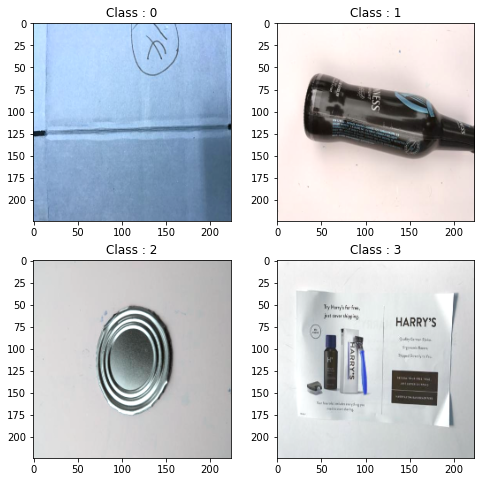

In [19]:
plt.figure(figsize=[8,8])

    # Display the first image in data
plt.subplot(221)
plt.imshow(X[0,:,:])
plt.title("Class : {}".format(y[0]))
#plt.colorbar(orientation="horizontal")

    # Display the second image
plt.subplot(222)
plt.imshow(X[525,:,:])
plt.title("Class : {}".format(y[525]))
#plt.colorbar(orientation="horizontal")

plt.subplot(223)
plt.imshow(X[750,:,:])
plt.title("Class : {}".format(y[750]))
#plt.colorbar(orientation="horizontal")

plt.subplot(224)
plt.imshow(X[1350,:,:])
plt.title("Class : {}".format(y[1350]))
#plt.colorbar(orientation="horizontal")
plt.show()

<b> Summary of steps done in this notebook </b>


Steps taken are

* We examined the original dataset which has six folders/classes - cardboard, glass, plastic, paper, metal & trash
* we observed that total datset size is 2527 images 
* We created two datatsets Train and Test data after solit original dataste with 25% of total data in test set
* We created h5py files with desired image size 224X224 and 3 channels for train and test data
* we loaded train datasile and plotted some random images

In next Notebook we will create different CNN models and train oiur dat and see the prediction accuracy and compare the models.
